Assignment 4 (Due: Wed, May 12, 2021)

The devised program estimates robustly, given very noisy and very sparse data of infected and recovered of a past epidemic, the basic reproduction number of the SIR model. To keep computation in limit, we assume gamma=1. The SIR model is implemented in a minimal and optimal way, using scaled variables and a scaled time. Only the ODE part is numerically integrated that needs to be integrated. The noisy number of infected and the number of recovered are highly correlated. This relationship helps MCMC infer the parameters. 

Get familiar with the commented MCMC code below.

Task:
Change the program to the SIRD model, by including (D)eaths, with rate $\mu$. Fix not only $\gamma=1$ but also $\beta=2.5$ (or to a higher value of your choice). 
Infer the death rate $\mu$, given noisy $S(t)$, $I(t)$, $R(t)$, $D(t)$ input curves.
If you want, you can try to optimze the code (optional, very very hard). 
Also optional is: Does the inference for $\mu$ work, if $S(t)$ and/or $R(t)$ are not given ?
You may use these (initial) conditions/parameters: $$i0 = 0.01, s0 = 0.99, r0 = 0, d0 = 0, f = 3.0, timestep = 0.5.$$
You may assume values for the respective $\sigma$'s (log-normal noises) in the range of $0.2-0.4$, but not lower than $0.1$. Good luck and have fun.

In [1]:
# Assignment 4: SIR model, MCMC for R0
# Jan Nagler
# based on https://docs.pymc.io/pymc-examples/examples/ode_models/ODE_API_introduction.htm
import numpy as np
import matplotlib.pyplot as plt
%precision 4 
%matplotlib inline
import pymc3 as pm #install if necessary
from pymc3.ode import DifferentialEquation
from scipy.integrate import odeint
import warnings
warnings.filterwarnings("ignore") 
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
np.random.seed(42)

In [32]:
f2 = 1.5
timestep_data = 1
a = np.arange(0, 10*f,timestep_data)
a

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14.])

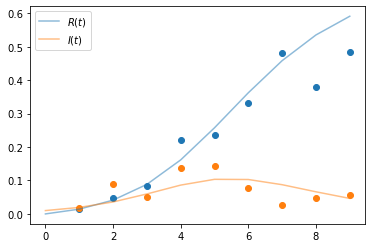

In [2]:
# Define initial conditions of SIR model
# S0 = N - I0 - R0
# N = 1
i0 = 0.01 #fractions infected at time t0=0 (1%)
r0 = 0.00 #fraction of recovered at time t0=0
f = 2 #3.0 # time factor - defines total time window range
timestep_data = 1 # dt for data (e.g., weekly)

############### 这里就是核心model，就是之前见过的SIR 积分model，这个model不再是Gaussian分布，因为他depend on time，则有不同的shape；  ODE SIR system, only parameter p[0]=R0=β, R0 = β / Ɣ for scaled time t/gamma (optimized, and 1=gamma)
def SIR(y, t, p):
    ############### ds = -p[0]*y[0]*y[1] = noise*I*R, we do not need susceptibles as S=1-I-R is dependent on I and R, 就形成了用I和R描述的一个S式子，用p[0]来模拟需要的两个参数即 β对应I，Ɣ对应R； 
    ############### y's compartment 0 = y[0] R = recovered；  y's compartment 1 = y[1] = I = infected
    ############### dr = y[1] # 因为gamma=1 也就是全部感染的人100%恢复，则本轮t的y[1]=下一个t+1的y[0]
    di = p[0]*(1-y[0]-y[1])*y[1] - y[1] 
    ############### SIR in one line: p[0]为noise，(1-y[0]-y[1])=1-R-I= S, 因为gamma=100%则本t内的y[1]就是下一轮t+1的R, 则有这样的关系 dI = p[0]*S*R - R  
    ############### 这里的p[0]相当于是用一个model来估计__________________________________________????
    return [y[1], di] 
    ############### return r(ecover) and i(nfect)，因为gamma=100%=1则第一项y[1]I的人全部Recover了,基本轮t内感染的人I全部变成下一轮Tt+1的恢复的人R

times = np.arange(0,5*f,timestep_data)

#ground truth (fixed gamma=1, then R0=beta, time scale to t/gamma)
beta = 1.7 ############### 就是infection % = β

# Create SIR curves
y = odeint(SIR, t=times, y0=[r0, i0], args=([beta],), rtol=1e-8) # r0 recovered, i0 infected  at t0

############### 这个就和之前的Y_obs一个意思，因Observational model 是专门 for muliplicative noise，因为下一个传染阶段取决于上一个传染阶段的人数，前后是proportional的，因此用lognormal Dist更合理
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.20, 0.60]) # noise is multiplicative (makes sense here)
#yobs = np.random.normal(loc=(y[1::]), scale=[0.030, 0.060]) # noise is additive (wrong here)############## 这个likelihood model对SIR积分model不可用

# Plot the deterministic curves, and those with multiplicative noise
plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$R(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

In [13]:
y

array([[0.    , 0.01  ],
       [0.0143, 0.0194],
       [0.0412, 0.0358],
       [0.0884, 0.0597],
       [0.1616, 0.0862],
       [0.2577, 0.1035],
       [0.3625, 0.1029],
       [0.4585, 0.0874],
       [0.5354, 0.0662],
       [0.5914, 0.0464]])

In [14]:
y[1::]

array([[0.0143, 0.0194],
       [0.0412, 0.0358],
       [0.0884, 0.0597],
       [0.1616, 0.0862],
       [0.2577, 0.1035],
       [0.3625, 0.1029],
       [0.4585, 0.0874],
       [0.5354, 0.0662],
       [0.5914, 0.0464]])

In [8]:
mean=np.log(y[1::])
mean

array([[-4.251 , -3.9402],
       [-3.1894, -3.3308],
       [-2.4259, -2.8178],
       [-1.8227, -2.4509],
       [-1.3559, -2.2683],
       [-1.0148, -2.2736],
       [-0.7797, -2.437 ],
       [-0.6247, -2.7157],
       [-0.5253, -3.0714]])

In [15]:
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.20,0.6])
yobs

array([[0.0141, 0.0497],
       [0.0244, 0.0586],
       [0.09  , 0.0499],
       [0.1646, 0.0262],
       [0.2466, 0.1282],
       [0.4871, 0.0754],
       [0.3901, 0.0647],
       [0.643 , 0.0806],
       [0.5319, 0.0631]])


Only 50 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [R0, sigma]


Sampling 2 chains for 1_000 tune and 50 draw iterations (2_000 + 100 draws total) took 257 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[0],0.24,0.07,0.14,0.38,0.01,0.01,84.0,61.0,1.01
sigma[1],0.63,0.18,0.35,0.87,0.02,0.02,96.0,80.0,1.06
R0,1.71,0.05,1.60,1.81,0.01,0.00,63.0,60.0,1.07


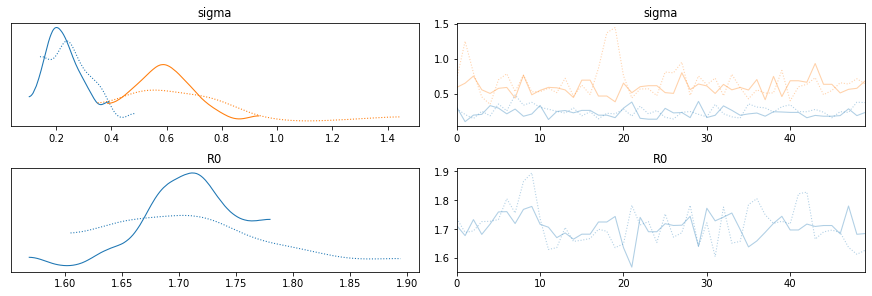

In [3]:
# ODE system container
sir_model = DifferentialEquation(
    func = SIR,
    times = np.arange(timestep_data,5*f,timestep_data), #start at t=t_1 (and not t0=0, where log(R=0)=undef)
    n_states = 2, #r(ecovered) and i(nfected) are states
    n_theta = 1, # beta=R0 only parameter
    t0 = 0 # start from zero
)

# Define and perform MCMC
with pm.Model() as basic_model:

    # Distribution of variances, sigma[0] and sigma[1], some good choice, pos. chauchy  
    sigma = pm.HalfCauchy( 'sigma', 1, shape=2 )

    # Prior: R0 is bounded from below (lower=1), (R0, mu=2, sigma=3)
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3 ) # guess of how R0 distribution looks like = Guassian, mean>1
    
    # Our deterministic curves
    sir_curves = sir_model( y0=[r0, i0], theta=[R0] ) # assume gamma = 1, then beta=R0

    # Likelihood function choice: our sampling distribution for multiplicative noise around the I and R curves
    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed=yobs) # variances via sigmas, data=yobs
    
    start = pm.find_MAP()
    
    step = pm.NUTS()
    
    trace = pm.sample(50, step=step, cores=1, random_seed=44) #set here number of cores, to adapt for hardware

# Plot results (takes a while, be patient)
pm.traceplot(trace)
pm.summary(trace).round(2)

array([[<AxesSubplot:ylabel='sigma\n1'>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='sigma\n0', ylabel='R0'>,
        <AxesSubplot:xlabel='sigma\n1'>]], dtype=object)

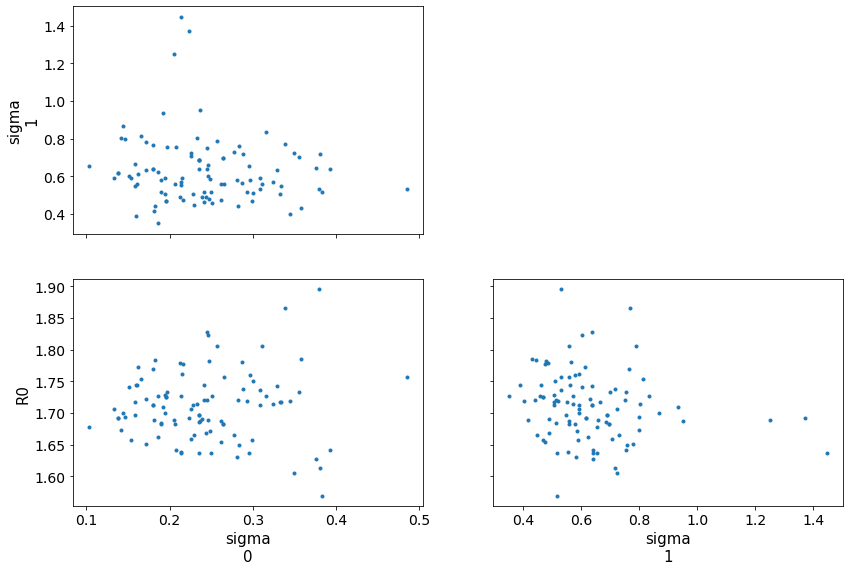

In [4]:
pm.pairplot(trace)

# Change the program to the SIRD model
By including (D)eaths, with rate $\mu$. Fix not only $\gamma=1$ but also $\beta=2.5$ (or to a higher value of your choice). 
Infer the death rate $\mu$, given noisy $S(t)$, $I(t)$, $R(t)$, $D(t)$ input curves.
If you want, you can try to optimze the code (optional, very very hard). 
Also optional is: Does the inference for $\mu$ work, if $S(t)$ and/or $R(t)$ are not given ?
You may use these (initial) conditions/parameters: $$i0 = 0.01, s0 = 0.99, r0 = 0, d0 = 0, f = 3.0, timestep = 0.5.$$
You may assume values for the respective $\sigma$'s (log-normal noises) in the range of $0.2-0.4$, but not lower than $0.1$. Good luck and have fun.

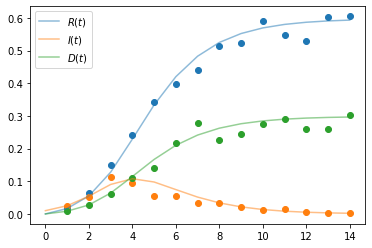

In [2]:
# Define initial conditions of SIR model
# S0 = N - I0 - R0
# N = 1
r0 = 0.00 #fraction of recovered at time t0=0
i0 = 0.01 #fractions infected at time t0=0 (1%)
d0 = 0.00 #fraction of dead at time t0=0
f = 3 #3.0 # time factor - defines total time window range
timestep_data = 1 # dt for data (e.g., weekly)

############### 这里就是核心model，就是之前见过的SIR 积分model，这个model不再是Gaussian分布，因为他depend on time，则有不同的shape；  ODE SIR system, only parameter p[0]=R0=β, R0 = β / Ɣ for scaled time t/gamma (optimized, and 1=gamma)
def SIR(y, t, p):
    ############### ds = -p[0]*y[0]*y[1] = noise*I*R, we do not need susceptibles as S=1-I-R is dependent on I and R, 就形成了用I和R描述的一个S式子，用p[0]来模拟需要的两个参数即 β对应I，Ɣ对应R； 
    ############### y's compartment 0 = y[0] R = recovered；  y's compartment 1 = y[1] = I = infected
    ############### dr = y[1] # 因为gamma=1 也就是全部感染的人100%恢复，则本轮t的y[1]=下一个t+1的y[0]
    di = p[0]*(1-y[0]-y[1]-p[1]*y[1])*y[1] -y[1] -p[1]*y[1]
    ############### SIR in one line: p[0]为noise，(1-y[0]-y[1])=1-R-I= S, 因为gamma=100%则本t内的y[1]就是下一轮t+1的R, 则有这样的关系 dI = p[0]*S*R - R  
    ############### 这里的p[0]相当于是用一个model来估计__________________________________________????
    return [y[1], di, p[1]*y[1]] 
    ############### return r(ecover) and i(nfect)，因为gamma=100%=1则第一项y[1]I的人全部Recover了,基本轮t内感染的人I全部变成下一轮Tt+1的恢复的人R

times = np.arange(0,5*f,timestep_data)

#ground truth (fixed gamma=1, then R0=beta, time scale to t/gamma)
beta = 2.5 ############### 就是infection % = β
mu =0.5

# Create SIR curves
y = odeint(SIR, t=times, y0=[r0, i0, d0], args=([beta, mu],), rtol=1e-8) # r0 recovered, i0 infected  at t0

############### 这个就和之前的Y_obs一个意思，因Observational model 是专门 for muliplicative noise，因为下一个传染阶段取决于上一个传染阶段的人数，前后是proportional的，因此用lognormal Dist更合理
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.1, 0.3, 0.1]) # noise is multiplicative (makes sense here)
#yobs = np.random.normal(loc=(y[1::]), scale=[0.030, 0.060]) # noise is additive (wrong here)############## 这个likelihood model对SIR积分model不可用

# Plot the deterministic curves, and those with multiplicative noise
plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$R(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.plot(times, y[:,2], color ='C2', alpha=0.5, label=f'$D(t)$')
plt.legend()
plt.show()


Only 200 samples in chain.
Sequential sampling (2 chains in 1 job)
NUTS: [mu, R0, sigma]


Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 432 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma[0],1.69,0.36,1.10,2.37,0.03,0.02,238.0,165.0,1.01
sigma[1],4.24,0.96,2.80,5.88,0.06,0.04,312.0,251.0,1.00
sigma[2],2.25,0.42,1.50,3.06,0.02,0.02,380.0,285.0,1.00
R0,1.52,0.46,1.02,2.23,0.02,0.02,394.0,307.0,1.01
mu,0.48,0.25,0.03,0.90,0.02,0.01,260.0,138.0,1.02


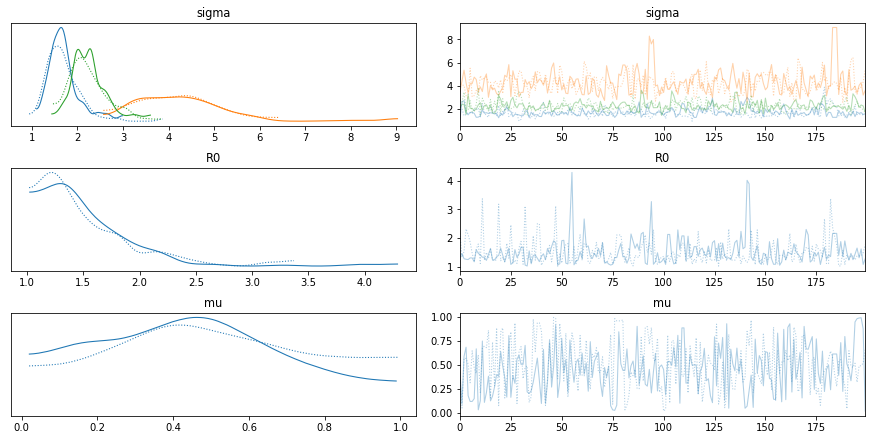

In [3]:
# ODE system container
sir_model = DifferentialEquation(
    func = SIR,
    times = np.arange(timestep_data, 5*f, timestep_data), #start at t=t_1 (and not t0=0, where log(R=0)=undef)
    n_states = 3, #R(ecovered), I(nfected) and D(ead) are states
    n_theta = 2, # beta=R0 and mu two parameter
    t0 = 0 # start from zero
)

# Define and perform MCMC
with pm.Model() as basic_model:

    # Distribution of variances, sigma[0] and sigma[1], some good choice, pos. chauchy  
    sigma = pm.HalfCauchy( 'sigma', 1, shape=3 )

    # Prior: R0 is bounded from below (lower=1), (R0, mu=2, sigma=3)
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2, 3 ) # guess of how R0 distribution looks like = Guassian, mean>1
    
    # Prior: mu is bounded from below (lower=0), (mu, mu=1, sigma=2)
    mu = pm.Bound(pm.Normal, lower=0.01, upper=1)('mu', 0.15, 0.5) # guess of how R0 distribution looks like = Guassian, mean>1
    
    # Our deterministic curves
    sir_curves = sir_model( y0=[r0, i0, d0], theta=[R0, mu] ) # assume gamma = 1, then beta=R0

    # Likelihood function choice: our sampling distribution for multiplicative noise around the I and R curves
    Y = pm.Lognormal('Y', mu=sir_curves, sd=sigma, observed=yobs) # variances via sigmas, data=yobs;"mu=pm.math.log(sir_curves)" Not working
    
    start = pm.find_MAP()
    
    step = pm.NUTS()
    
    trace = pm.sample(200, step=step, cores=1, random_seed=44) #set here number of cores, to adapt for hardware

# Plot results (takes a while, be patient)
pm.traceplot(trace)
pm.summary(trace).round(2)

array([[<AxesSubplot:ylabel='sigma\n1'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='sigma\n2'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:ylabel='R0'>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='sigma\n0', ylabel='mu'>,
        <AxesSubplot:xlabel='sigma\n1'>, <AxesSubplot:xlabel='sigma\n2'>,
        <AxesSubplot:xlabel='R0'>]], dtype=object)

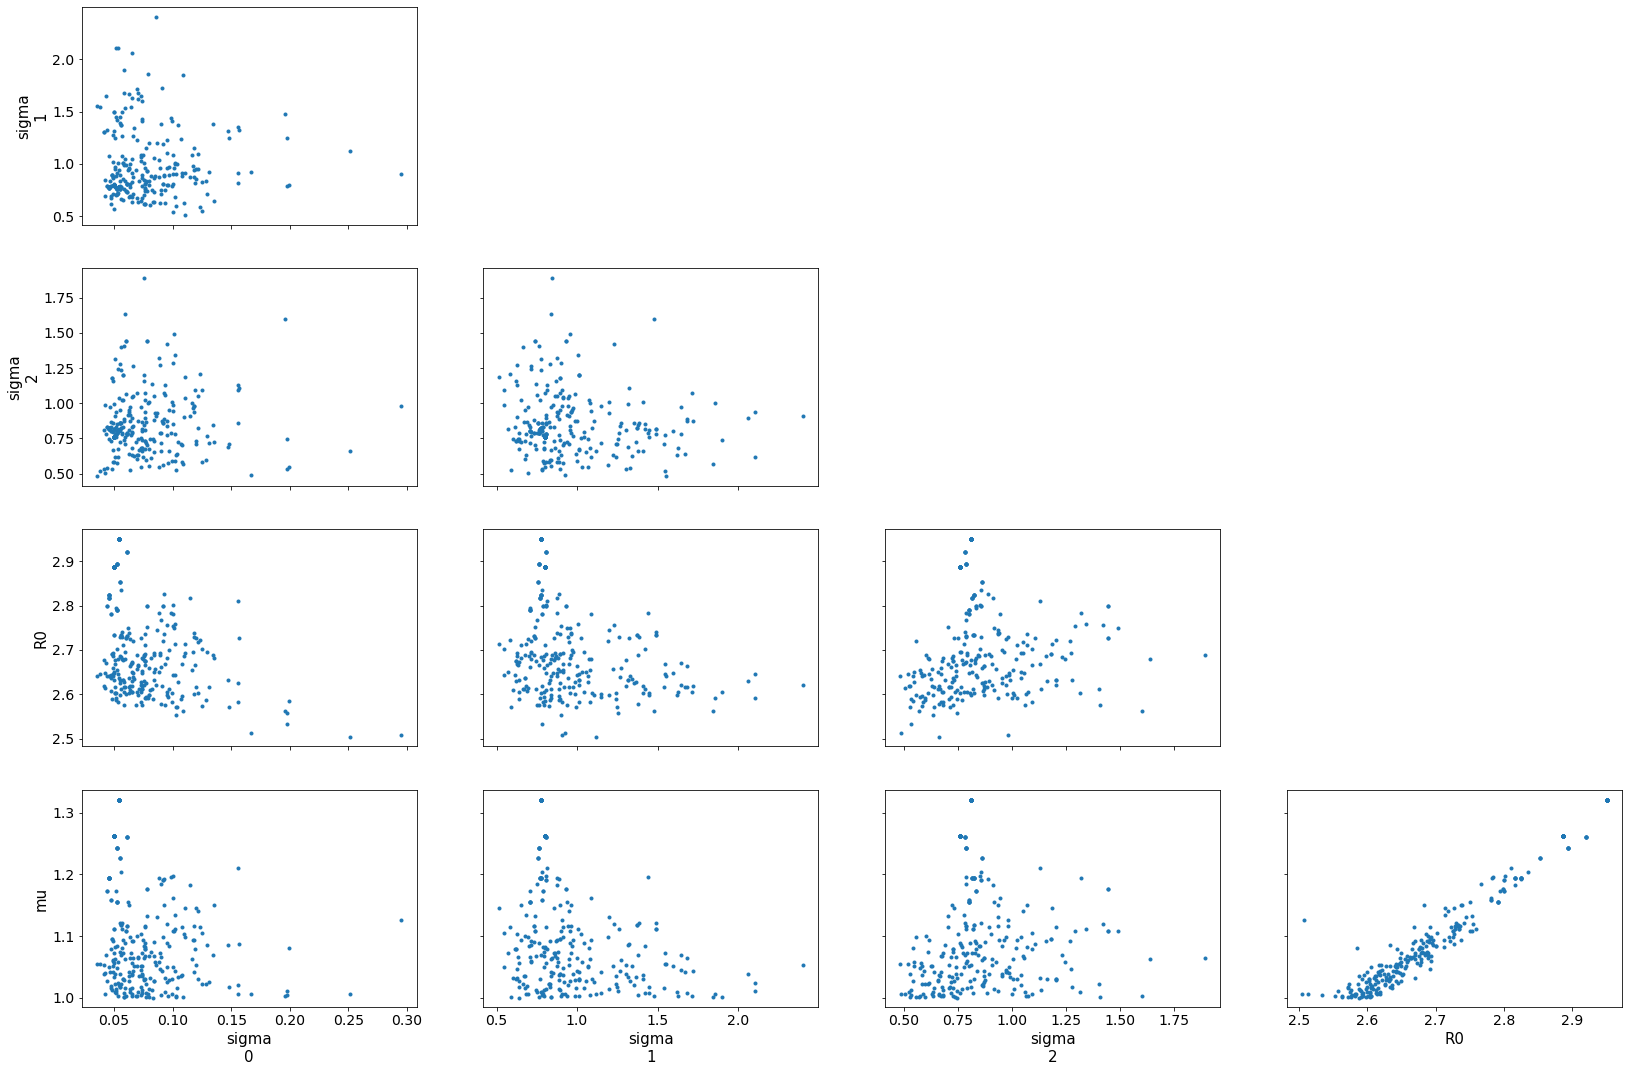

In [7]:
pm.pairplot(trace)